In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
#import cv2
from PIL import Image
from warnings import filterwarnings
filterwarnings("ignore")

HEIGHT = 120
WEIGHT = 120

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)
    #print(os.path.join(dirname, filename))

In [2]:
import tensorflow #le notebook ne fonctionne qu'avec TF2  
#Notamment avec TF 2.3.0 et Keras 2.4.3 ok (sinon il peut y avoir des soucis de versions)
print(tensorflow.__version__)

2.3.0


In [3]:
train_dirs = ["kaggle/input/withwithout-mask/maskdata/maskdata/train",
             "kaggle/input/withwithout-mask/masks2.0/masks/train",
             "kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train",
             "kaggle/input/faces-with-masks"]

test_dirs = ["kaggle/input/withwithout-mask/maskdata/maskdata/test",
            "kaggle/input/withwithout-mask/masks2.0/masks/test",
            "kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test",
            "kaggle/input/face-mask-detection/dataset"]

validation_dirs = ["kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation"]


In [4]:
fullimg = []
for dirname, _, filenames in os.walk('kaggle/input'):
    for filename in filenames:
        fullimg.append(os.path.join(dirname, filename))
        

# Preprocessing

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_generator = ImageDataGenerator(rescale=1./255,
                                         zoom_range=0.2,
                                         shear_range=0.2,
                                         rotation_range=0.2)

test_data_generator = ImageDataGenerator(rescale=1./255)

validation_data_generator = ImageDataGenerator(rescale=1./255,
                                         zoom_range=0.2,
                                         shear_range=0.2)

In [6]:
print("Flowing Train")
train_generator1 = train_data_generator.flow_from_directory(
        train_dirs[0],
        target_size=(HEIGHT,WEIGHT),
        batch_size=77,
        interpolation="nearest",
        class_mode='binary',
        classes=["without_mask","with_mask"])
train_generator2 = train_data_generator.flow_from_directory(
        train_dirs[1],
        target_size=(HEIGHT,WEIGHT),
        batch_size=46,
        interpolation="nearest",
        class_mode='binary',
        classes=["0","1"])
train_generator3 = train_data_generator.flow_from_directory(
        train_dirs[2],
        target_size=(HEIGHT,WEIGHT),
        batch_size=80,
        interpolation="nearest",
        class_mode='binary',
        classes=["WithoutMask","WithMask"])
train_generator4 = train_data_generator.flow_from_directory(
        train_dirs[3],
        target_size=(HEIGHT,WEIGHT),
        batch_size=163,
        interpolation="nearest",
        class_mode='binary',
        classes=["_","faces_with_mask"])

print("\nFlowing Test")
test_generator1 = test_data_generator.flow_from_directory(
        test_dirs[0],
        target_size=(HEIGHT,WEIGHT),
        batch_size=66,
        interpolation="nearest",
        class_mode='binary',
        classes=["without_mask","with_mask"])
test_generator2 = test_data_generator.flow_from_directory(
        test_dirs[1],
        target_size=(HEIGHT,WEIGHT),
        batch_size=11,
        interpolation="nearest",
        class_mode='binary',
        classes=["0","1"])
test_generator3 = test_data_generator.flow_from_directory(
        test_dirs[2],
        target_size=(HEIGHT,WEIGHT),
        batch_size=62,
        interpolation="nearest",
        class_mode='binary',
        classes=["WithoutMask","WithMask"])
test_generator4 = test_data_generator.flow_from_directory(
        test_dirs[3],
        target_size=(HEIGHT,WEIGHT),
        batch_size=55,
        interpolation="nearest",
        class_mode='binary',
        classes=["without_mask","with_mask"])
print("\nFlowing Validation")
validation_generator1 = validation_data_generator.flow_from_directory(
        validation_dirs[0],
        target_size=(HEIGHT,WEIGHT),
        batch_size=80,
        interpolation="nearest",
        class_mode='binary',
        classes=["WithoutMask","WithMask"])
withWithoutMask = {"0":"Without Mask","1":"With Mask"}

Flowing Train
Found 616 images belonging to 2 classes.
Found 92 images belonging to 2 classes.
Found 95 images belonging to 2 classes.
Found 6 images belonging to 2 classes.

Flowing Test
Found 198 images belonging to 2 classes.
Found 33 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 440 images belonging to 2 classes.

Flowing Validation
Found 800 images belonging to 2 classes.


In [7]:
def genToTuple(gen):
    templist = []
    templist2 = []
    #print(gen) #debugg
    #print(gen.__len__()) #debugg
    for i in range(gen.__len__()):
        tempnext = gen.next()
        templist.append(tempnext[0])
        templist2.append(tempnext[1])
    x=np.concatenate(templist)
    y=np.concatenate(templist2)
    return (x,y)

def combine_tuple(*tuples):
    x=np.concatenate([tuples[i][0] for i in range(len(tuples))])
    y=np.concatenate([tuples[i][1] for i in range(len(tuples))])
    return (x,y.astype(int))

#Debug
#templisttest=[]
#nexttemp=train_generator1.next()
#templisttest.append(nexttemp[0])
#print(templisttest)
    
train_generator1_t = genToTuple(train_generator1)
train_generator2_t = genToTuple(train_generator2)
train_generator3_t = genToTuple(train_generator3)
train_generator4_t = genToTuple(train_generator4)

test_generator1_t = genToTuple(test_generator1)
test_generator2_t = genToTuple(test_generator2)
test_generator3_t = genToTuple(test_generator3)
test_generator4_t = genToTuple(test_generator4)



x_train,y_train = combine_tuple(train_generator1_t,train_generator2_t,train_generator3_t,train_generator4_t)
x_test,y_test = combine_tuple(test_generator1_t,test_generator2_t,test_generator3_t,test_generator4_t)

x_val,y_val = genToTuple(validation_generator1)

In [8]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
print(x_val.shape,y_val.shape)

(809, 120, 120, 3) (809,)
(1663, 120, 120, 3) (1663,)
(800, 120, 120, 3) (800,)


# Build Model

In [9]:
#switch from keras to tf.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, SpatialDropout2D, BatchNormalization, Input, Activation, Dense, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import binary_crossentropy

def build_model():
        model = tensorflow.keras.Sequential()
        model.add(Input(shape=(HEIGHT,WEIGHT,3,)))

        model.add(Conv2D(filters=16,kernel_size=(2,2),padding="same"))
        model.add(Activation("relu"))
        model.add(SpatialDropout2D(0.25))
        
        model.add(MaxPool2D(pool_size=(4,4)))

        model.add(Conv2D(filters=32,kernel_size=(2,2),padding="same"))
        model.add(Activation("relu"))
        model.add(SpatialDropout2D(0.25)) #bug
        
        model.add(MaxPool2D(pool_size=(4,4),strides=(4,4)))
               
        model.add(Flatten())
        
        model.add(Dense(2048))
        model.add(Activation("relu"))
        model.add(Dropout(0.25))
        
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(Dropout(0.2))
        
        
        model.add(Dense(1))
        model.add(Activation("sigmoid"))
        
        optimizer = Adam(lr=0.001)
        model.compile(optimizer = optimizer ,metrics=["accuracy"], loss = binary_crossentropy)
        
        return model

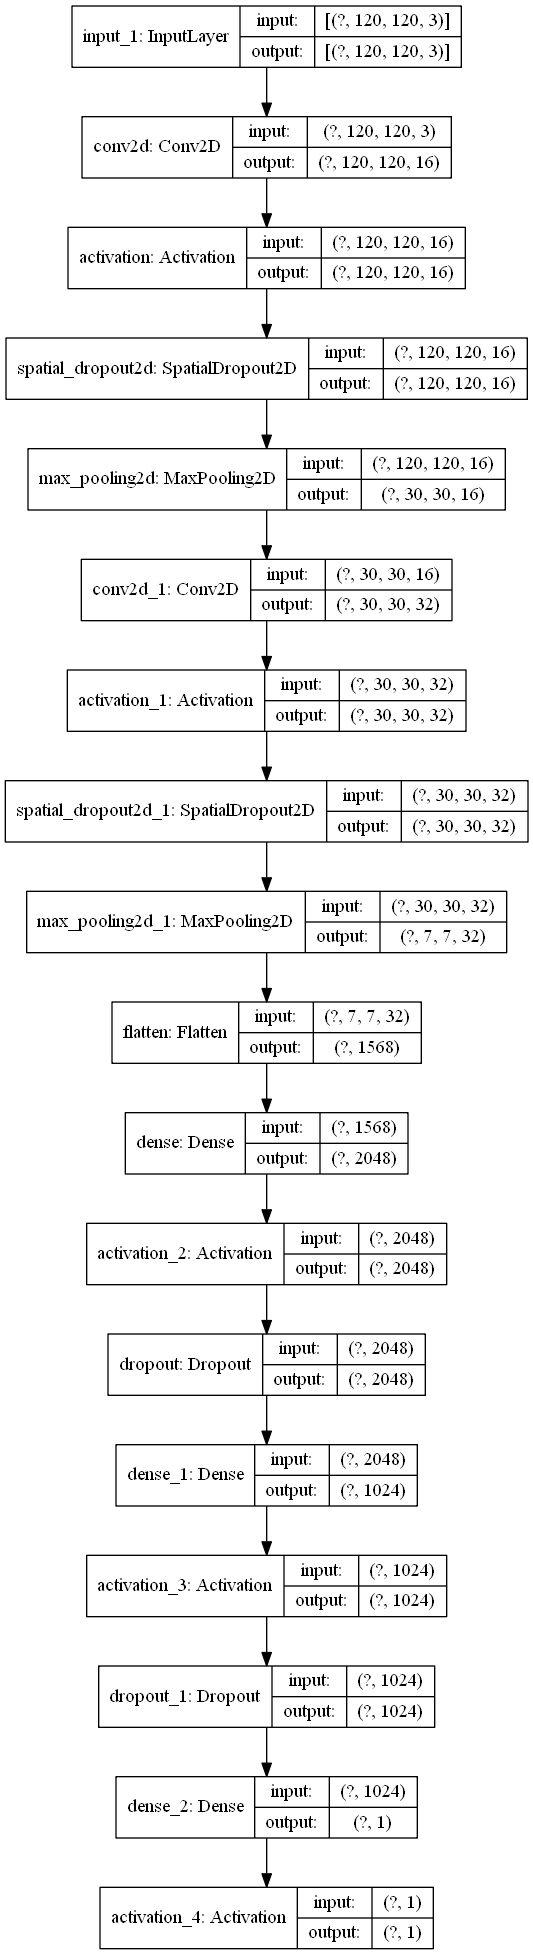

In [10]:
#conda install pydot 
#Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
model = build_model()
plot_model(model,show_shapes=True,show_layer_names=True)

# Train Model

In [11]:
reducer = ReduceLROnPlateau(monitor='loss',patience=3,factor=0.75,min_lr=0.000001,verbose=1)
stopSign = EarlyStopping(monitor = "loss",patience=20,min_delta=0.000000000001,mode="min")

epochs = 5 #1000000
batch_size = 32
steps_per_epoch = x_train.shape[0] // batch_size
history = model.fit(x_train,y_train,
                    epochs = epochs, 
                    validation_data = (x_val,y_val),
                    verbose = 1,
                    batch_size=batch_size,
                    steps_per_epoch = steps_per_epoch,
                    callbacks=[reducer,stopSign])

Epoch 1/5
25/25 [==============================] - 16s 642ms/step - loss: 0.7195 - accuracy: 0.5575 - val_loss: 0.5835 - val_accuracy: 0.8712
Epoch 2/5
25/25 [==============================] - 11s 450ms/step - loss: 0.5397 - accuracy: 0.7477 - val_loss: 0.3824 - val_accuracy: 0.8825
Epoch 3/5
25/25 [==============================] - 10s 411ms/step - loss: 0.3508 - accuracy: 0.8507 - val_loss: 0.3380 - val_accuracy: 0.8800
Epoch 4/5
25/25 [==============================] - 10s 392ms/step - loss: 0.2628 - accuracy: 0.9060 - val_loss: 0.3794 - val_accuracy: 0.8637
Epoch 5/5
25/25 [==============================] - 10s 413ms/step - loss: 0.1871 - accuracy: 0.9369 - val_loss: 0.3755 - val_accuracy: 0.8763


# Save Model

In [12]:
model.save('trained_model') #NEW

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: trained_model\assets


# Prediction

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


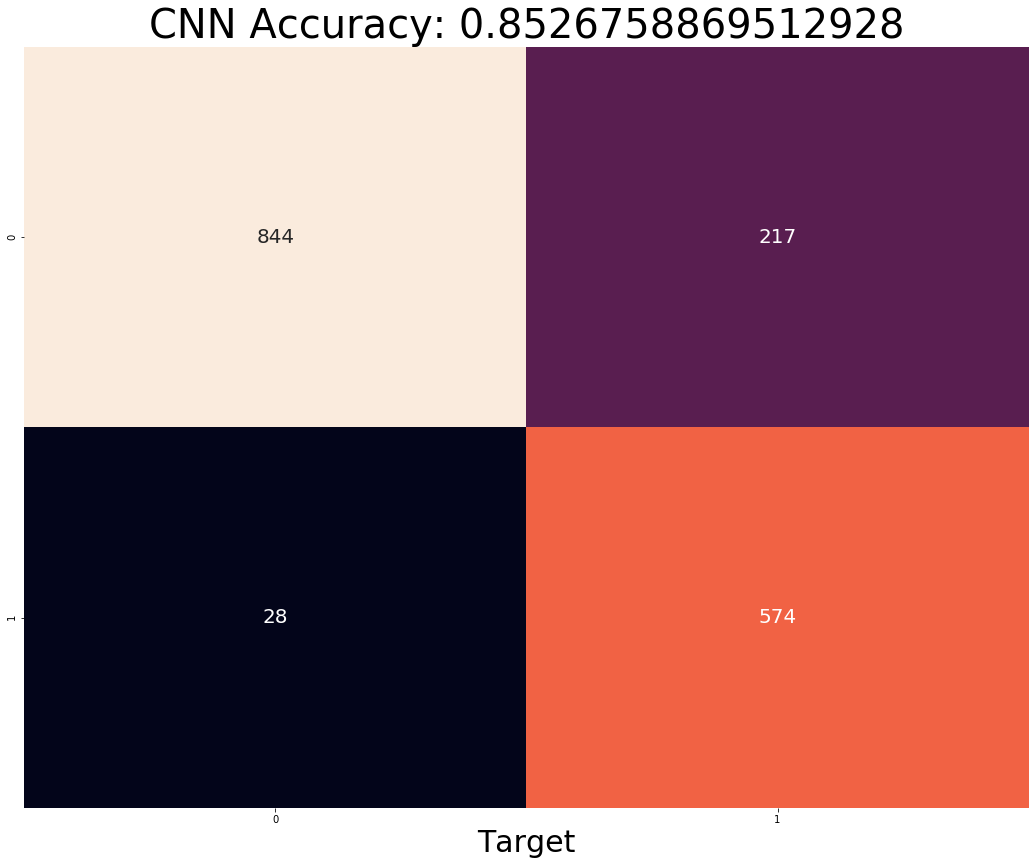

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

ypred = model.predict_classes(x_test)
plt.subplots(figsize=(18,14))
sns.heatmap(confusion_matrix(ypred,y_test),annot=True,fmt="1.0f",cbar=False,annot_kws={"size": 20})
plt.title(f"CNN Accuracy: {accuracy_score(ypred,y_test)}",fontsize=40)
plt.xlabel("Target",fontsize=30)
plt.show()

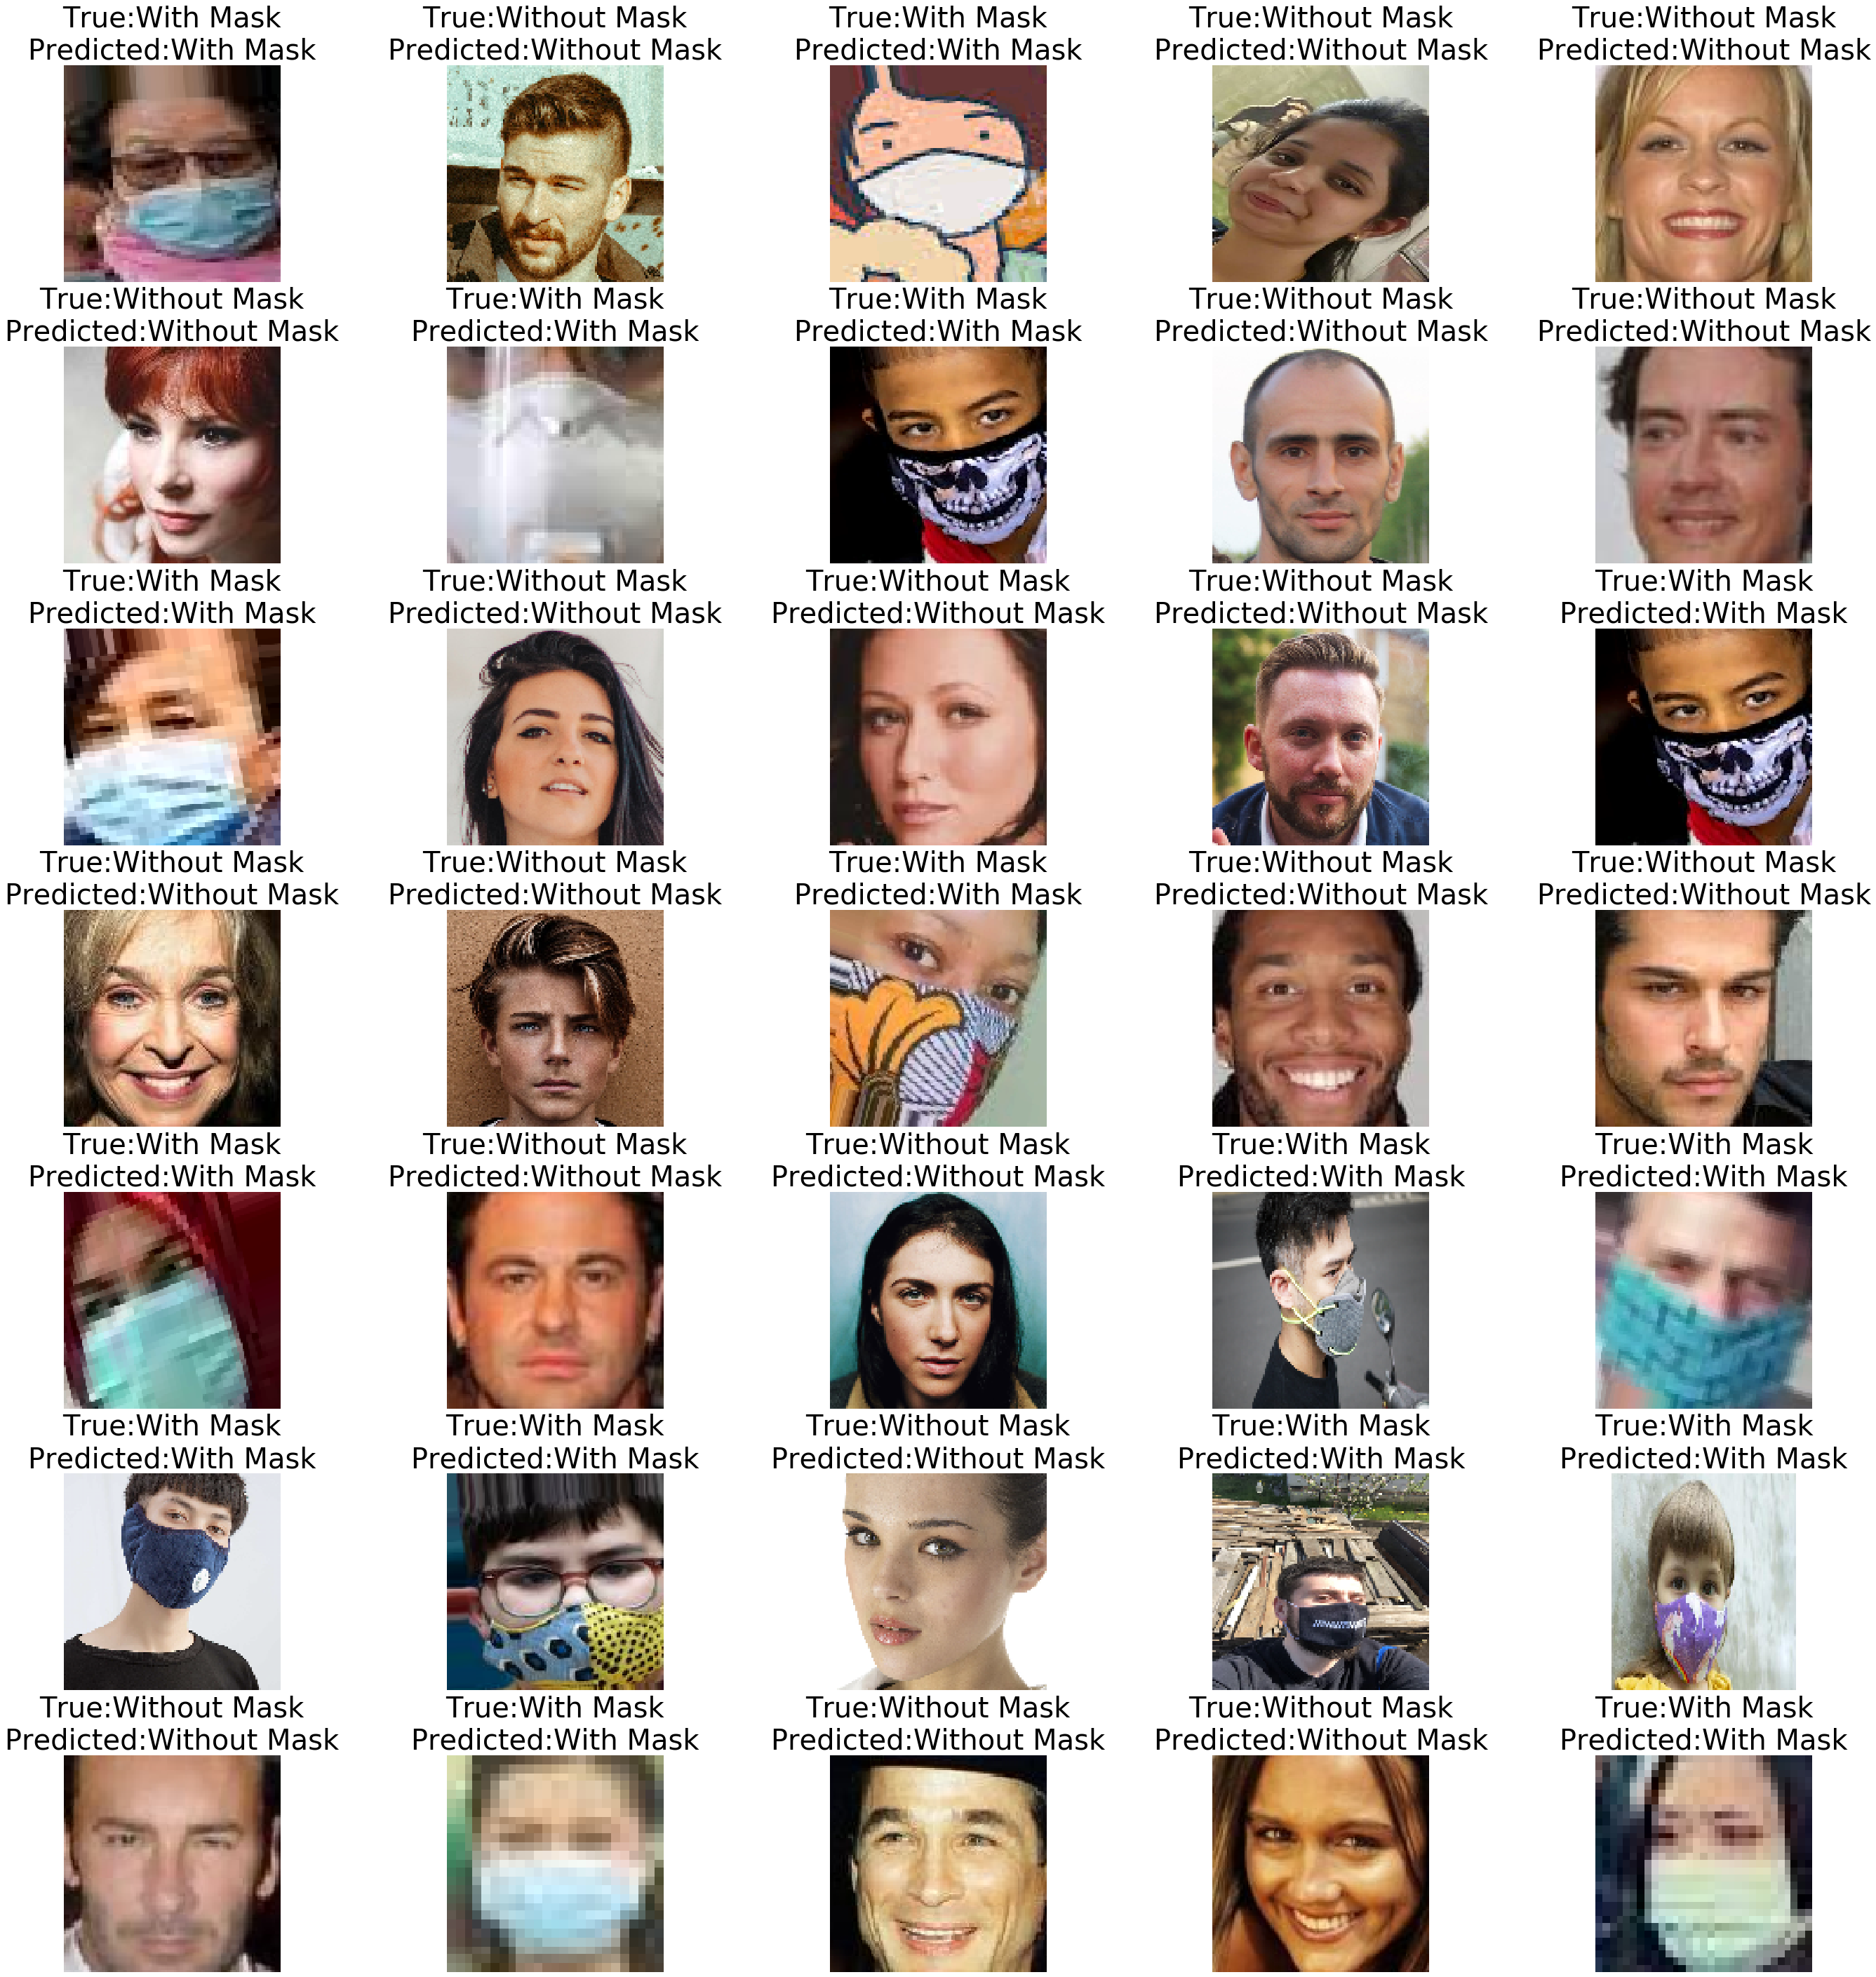

In [14]:
plt.figure(figsize=(50,50))
tempc = np.random.choice(x_test[y_test == ypred.ravel()].shape[0],35,replace=False)
d = 0
for i in tempc:
    plt.subplot(7, 5, d+1)
    d += 1
    tempc = np.random.randint(x_test[y_test == ypred.ravel()].shape[0])
    plt.imshow(x_test[y_test == ypred.ravel()][tempc])
    plt.title(f"True:{withWithoutMask[str(y_test[y_test == ypred.ravel()][tempc])]}\nPredicted:{withWithoutMask[str(ypred.ravel()[y_test == ypred.ravel()][tempc])]}",
              fontsize=40)
    plt.axis("off")
plt.subplots_adjust(wspace=-0.1, hspace=0.3)
plt.show()

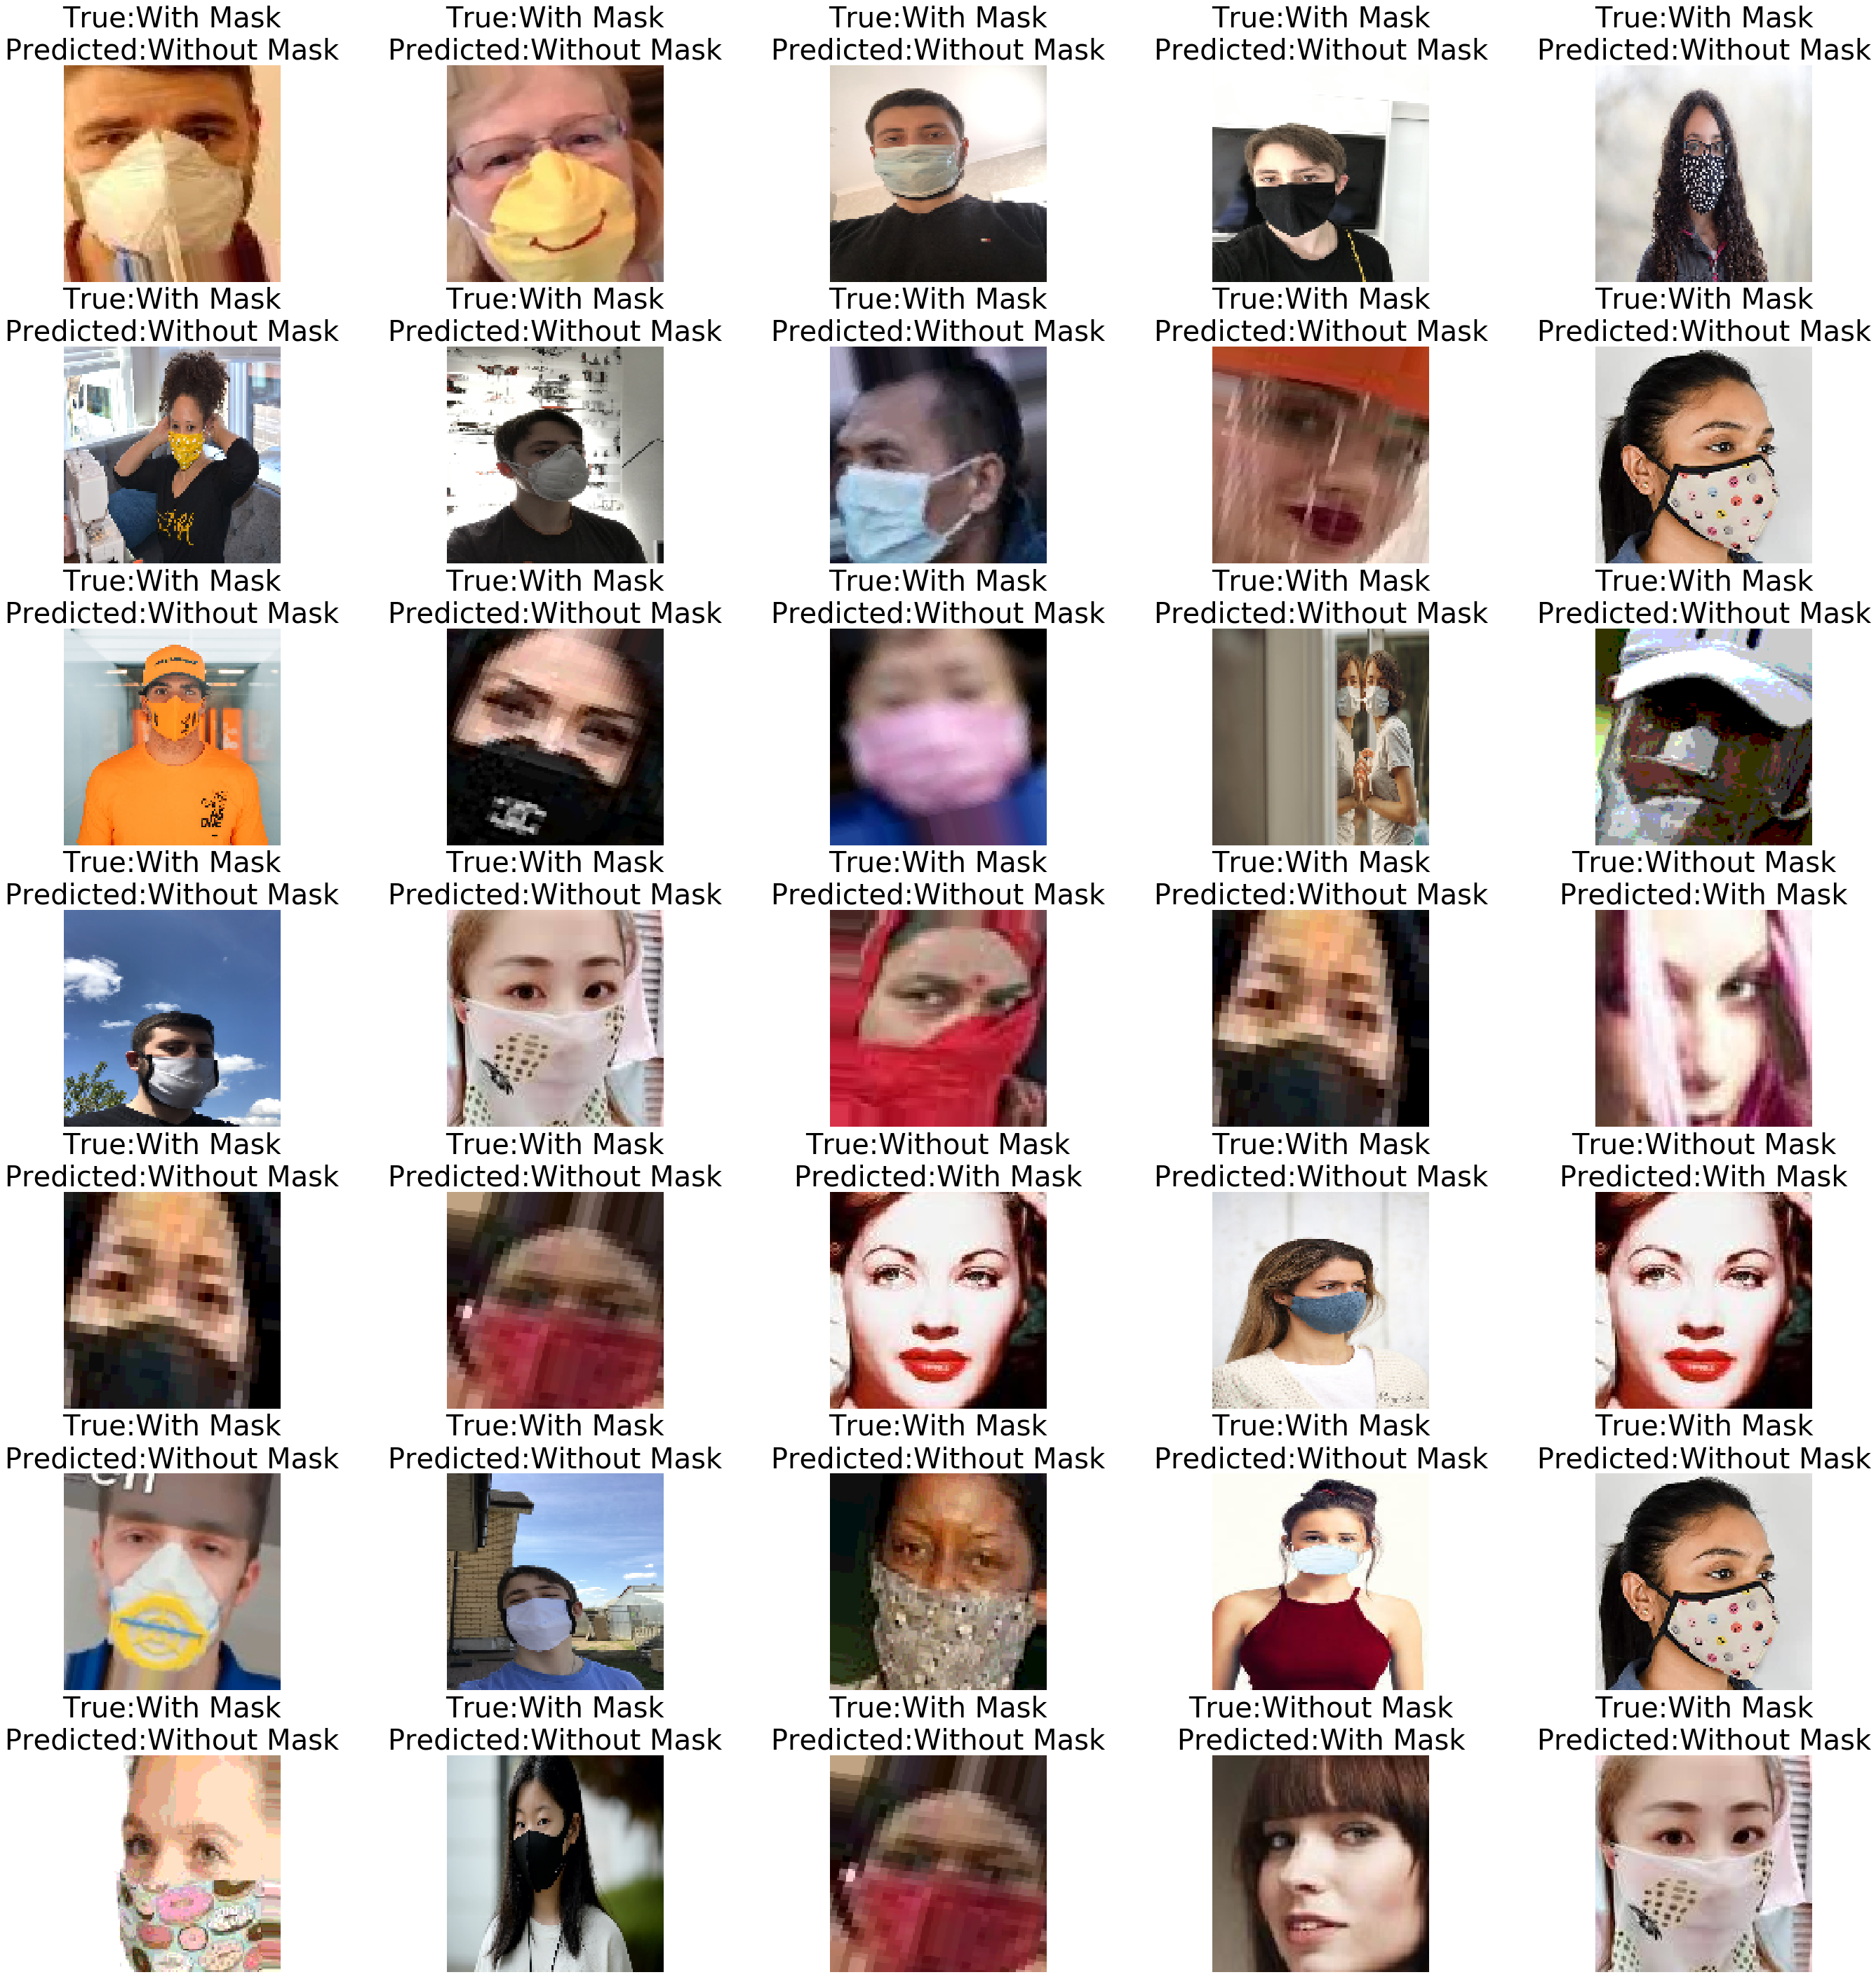

In [15]:
plt.figure(figsize=(50,50))
tempc = np.random.choice(x_test[y_test != ypred.ravel()].shape[0],35,replace=False)
d = 0
for i in tempc:
    plt.subplot(7, 5, d+1)
    d += 1
    tempc = np.random.randint(x_test[y_test != ypred.ravel()].shape[0])
    plt.imshow(x_test[y_test != ypred.ravel()][tempc])
    plt.title(f"True:{withWithoutMask[str(y_test[y_test != ypred.ravel()][tempc])]}\nPredicted:{withWithoutMask[str(ypred.ravel()[y_test != ypred.ravel()][tempc])]}",
             fontsize=40)
    plt.axis("off")
plt.subplots_adjust(wspace=-0.1, hspace=0.3)
plt.show()